In [1]:
import h5py
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2
from tqdm.auto import tqdm
import arpesnet as an

from knano.cluster import Cluster
import knano.transform as transform
from numpy.random import RandomState
import xarray as xr

# Klargøring af ARPES

In [2]:
print("Loading trainer")
trainerPath = r"C:\Users\Alexa\Dropbox\Pc\Documents\Privat\Programering\Visual studio\Uni\Bachelor\General coding stuff\ARPES_on_the_fly_arpesnet_206c328\trained_model\arpesnet_n2n_4k.pth"
# trainerPath = r"C:\Users\Alexa\Dropbox\Pc\Documents\Privat\Programering\Visual studio\Uni\Bachelor\Deres\ARPES_on_the_fly_arpesnet_206c328\trained_by_me\arpesnet_60epochs_001.pt"
trainer = an.core.load_trainer(trainerPath)
print("Trainer loaded\n")

encoder = trainer.encoder
decoder = trainer.decoder

encoder.eval()
decoder.eval()

INPUT_SHAPE = (256, 256)
NORM_RANGE = (0, 10)

preprocess = an.transform.Compose(
    [an.transform.Resize(INPUT_SHAPE), an.transform.NormalizeMinMax(*NORM_RANGE)]
)
testing_augmentations = an.transform.Compose(
    [
        an.transform.Resize(INPUT_SHAPE),
        an.transform.NormalizeMinMax(*NORM_RANGE),
    ]
)

def useARPES_on_img(img, pri):
    img = torch.from_numpy(img)
    img = preprocess(img)
    if(pri): print(img)
    img = testing_augmentations(img)
    rec = decoder(encoder(img.unsqueeze(0))).detach().squeeze().cpu().numpy()
    img = img.detach().squeeze().cpu().numpy()
    return img, rec
print("Machine learning reconstruction is ready")

Loading trainer
GPU not available, using CPU
Trainer loaded

Machine learning reconstruction is ready


c:\Users\Alexa\anaconda3\lib\site-packages\arpesnet\core.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded = torch.load(filepath)
c:\Users\Alexa\anaconda3\lib\site

# Load the data


In [3]:
def h5_tree(val, pre=''):
    items = len(val)
    for key, val in val.items():
        items -= 1
        if items == 0:
            # the last item
            if type(val) == h5py._hl.group.Group:
                print(pre + '└── ' + key)
                h5_tree(val, pre+'    ')
            else:
                try:
                    print(pre + '└── ' + key + ' (%d)' % len(val))
                except TypeError:
                    print(pre + '└── ' + key + ' (scalar)')
        else:
            if type(val) == h5py._hl.group.Group:
                print(pre + '├── ' + key)
                h5_tree(val, pre+'│   ')
            else:
                try:
                    print(pre + '├── ' + key + ' (%d)' % len(val))
                except TypeError:
                    print(pre + '├── ' + key + ' (scalar)')

In [4]:
# filename = "Cleave3_14.h5"        # 2,92 Gb
# filename = "GPScan_5.h5"          # 0,66 Gb
# filename = "GPScan_133_1.h5"      # 3,96 Gb
filename = "gr_flake_full.h5"     # 0,49 Gb
# filename = "misfit_Se3d_512.h5"   # 0,04 Gb
# filename = "misfit_Se3d_full.h5"  # 0,44 Gb

DATA_DIR = Path(os.path.dirname(os.getcwd())) / "Main Data" / filename

#Open the H5 file in read mode
with h5py.File(DATA_DIR, 'r') as file:
    h5_tree(file)
    
    if(filename in ["GPScan_133_1.h5", "GPScan_5.h5", "Cleave3_14.h5"]):
        print(file["Entry"]["Data"]["ScanDetails"]["Dim1_name"])
        det = list(file["Entry"]["Data"]["ScanDetails"])
        for d in det:
            try:
                ele = list(file["Entry"]["Data"]["ScanDetails"][d])
                print(f"{d}: {ele}")
            except:
                pass
        pos = np.array(list(file["Entry"]["Data"]["ScanDetails"]["TruePositions"]))
        xer = np.copy(pos[:, 1])
        yer = np.copy(pos[:, 0])

        xer -= np.min(xer)
        yer -= np.min(yer)

        steps = list(file["Entry"]["Data"]["ScanDetails"]["SlowAxis_step"])
        xer /= abs(steps[0])
        yer /= abs(steps[1])


        data = np.array(list(file["Entry"]["Data"]["TransformedData"]))

        axisData = {
            "dims": (int(max(xer))+1, int(max(yer))+1, data.shape[1], data.shape[2]),
            "coords": np.array(list(zip(xer, yer))).astype(int),
            "ori_coords": pos
            # "axis_names": 
            # "x2": 
            # "y2": 
        }

    elif(filename in ["gr_flake_full.h5", "misfit_Se3d_512.h5", "misfit_Se3d_full.h5"]):
        groupKeys = list(file.keys())
        axisNames = list(file[groupKeys[0]])
        dataCoords = [list(file[groupKeys[0]][axisNames[2]]), list(file[groupKeys[0]][axisNames[3]])]
        data = np.array(list(file[groupKeys[1]]))
        dataShape = data.shape
        data = np.reshape(data, (dataShape[0]*dataShape[1], dataShape[2], dataShape[3]))

        axisData = {
            "dims": dataShape,
            "coords": np.array([(x, y) for x in dataCoords[0] for y in dataCoords[1]]),
            "ori_coords": np.array([(x, y) for x in dataCoords[0] for y in dataCoords[1]]),
            "axis_names": axisNames
        }

    else:
        print("\nNo method defined for this file")

print()
print(filename)
data = np.array(data)
if(len(data.flatten()) > 20): print(f"data shape = {data.shape}")
else: print(f"{data=}")


print(f"dim = {axisData['dims']}")


dimension_labels = ["x", "y", "e", "k"]
dimension_sizes = (axisData["dims"][0], axisData["dims"][1], 256, 256)
# print(axisData["axis_names"])
print(dimension_labels)
print(dimension_sizes)



├── coords
│   ├── angle (290)
│   ├── energy (260)
│   ├── posx (49)
│   └── posy (39)
├── data (49)
└── dims (4)

gr_flake_full.h5
data shape = (1911, 290, 260)
dim = (49, 39, 290, 260)
['x', 'y', 'e', 'k']
(49, 39, 256, 256)


Good file :)


Text(0.5, 1.0, 'Active coordinates')

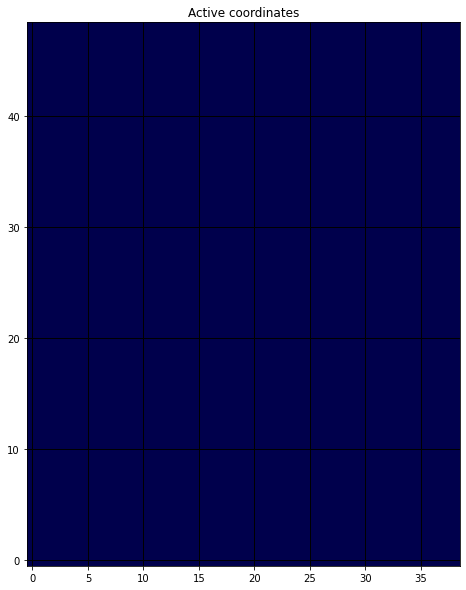

In [5]:
img = np.zeros(axisData["dims"][:2]) +1
x_res = 0
for i, j in axisData["coords"]: img[int(i), int(j)] = 0

godfil = True

if(data.shape[0] != img.shape[0]*img.shape[1]): 
    fig, axes = plt.subplot_mosaic([["ori"]], figsize=(30, 30))
    print("Bad file :(")
    godfil = False
else: 
    fig, axes = plt.subplot_mosaic([["ori"]], figsize=(10, 10))
    print("Good file :)")
clim = img.min(), img.max()
axes["ori"].imshow(img, cmap="seismic", clim=clim, origin="lower")
axes["ori"].grid(color='k', linestyle='-', linewidth=1)
axes["ori"].set_title("Active coordinates")


In [6]:
def getIndexFromCoord(coords):
    return np.where((axisData["coords"] == coords).all(1))[0][0]

def setup(dataHere, index):
    if("diff" in dataHere.keys()):
        grid = [["ori", "rec", "diff"],]
        fig, axes = plt.subplot_mosaic(grid, figsize=(12, 6))
        fig.subplots_adjust(wspace=0.2)

        showImgs = [dataHere["img"][index],
                    dataHere["rec"][index],
                    dataHere["diff"][index],]
        names = [name if(name != "diff") else f"Diff\nloss: {dataHere['loss'][index]}" for name in grid[0]]

        return grid, fig, axes, showImgs, names
    else:
        grid = [["ori", "rec"],]
        fig, axes = plt.subplot_mosaic(grid, figsize=(12, 6))
        fig.subplots_adjust(wspace=0.2)

        showImgs = [dataHere["img"][index],
                    dataHere["rec"][index],]
        names = [name for name in grid[0]]

        return grid, fig, axes, showImgs, names

processedData = {}

def showCoord(coords=None, index=None, imgs=None, dataHere=processedData, title=None):
    showImgs = []

    if(coords != None and index == None and imgs == None):
        index = getIndexFromCoord(coords)
        grid, fig, axes, showImgs, names = setup(dataHere, index)
        
        fig.suptitle(f"index = {index}\n({coords[0]}, {coords[1]})", fontsize=16)
        
    elif(coords == None and index != None and imgs == None):
        grid, fig, axes, showImgs, names = setup(dataHere, index)
        
        s = axisData["coords"][index]
        fig.suptitle(f"index = {index}\n({s[0]}, {s[1]})", fontsize=16)

    elif(coords == None and index == None and imgs != None):
        grid = [[name for _, name in imgs]]
        fig, axes = plt.subplot_mosaic(grid, figsize=(12, 6))
        fig.subplots_adjust(wspace=0.2)
        if(title != None): fig.suptitle(title, fontsize=16)

        showImgs = [img for img, _ in imgs]
        names = np.copy(grid[0])
    else:
        print("****************************************************************")
        print("Showing the default img: index = 0")
        print("****************************************************************")
        showCoord(index=0)
        return None
    
    for nr, key in enumerate(grid[0]):
        clim = showImgs[nr].min(), showImgs[nr].max()
        axes[key].imshow(showImgs[nr], cmap="viridis", clim=clim, origin="lower")
        axes[key].set_title(names[nr])

def turnBackToGrid(a, axisStuff, defaultVal = -1):
    coords = axisStuff["coords"]
    zeros = np.zeros(axisStuff["dims"][:2]) - defaultVal
    for nr, (x, y) in enumerate(coords):
        zeros[x, y] = a[nr]
    return zeros                           #-1 er default fejl-værdien


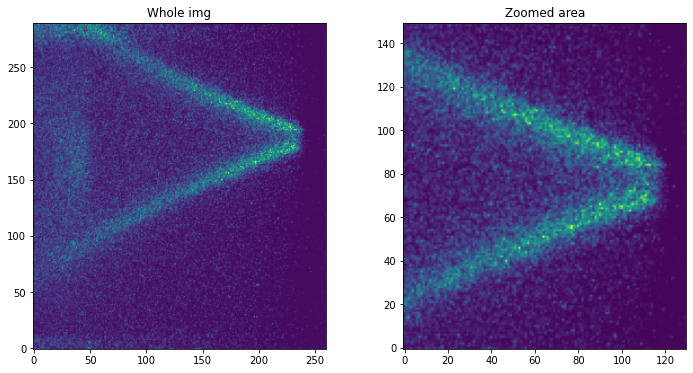

In [7]:
AOI = {  #Area of interest [y, x]
    "Cleave3_14.h5"      : [[],[]],
    "GPScan_5.h5"        : [[],[]],
    "GPScan_133_1.h5"    : [[],[]],
    "gr_flake_full.h5"   : [[110,260],[120,250]],#[[140,230],[175,250]],
    "misfit_Se3d_512.h5" : [[],[]],
    "misfit_Se3d_full.h5": [[],[]],
}
try:
    # img = data[getIndexFromCoord([1, 15])]
    img = data[int(dimension_sizes[0]/2) * dimension_sizes[0] + int(dimension_sizes[1]/2)]
    a = AOI[filename]
    smallImg = img[a[0][0]:a[0][1], a[1][0]:a[1][1]]
    showCoord(imgs=[[img, "Whole img"], [smallImg, "Zoomed area"]])
except:
    a = [[0, dimension_sizes[2]], [0, dimension_sizes[3]]]

# Using ARPES on all the chosen coordinates

In [8]:
processedData = {
    "img": [],
    "rec": [],
    "diff": [],
    "loss": []
}
for nr, (x, y) in enumerate(axisData["coords"][:]):
    img = data[nr, a[0][0]:a[0][1], a[1][0]:a[1][1]]
    img, rec = useARPES_on_img(img, pri=False)
    # img = np.nan_to_num(img, nan=0)
    # rec = np.nan_to_num(rec, nan=0)
    # if(np.sum(img) == 0):
    #     print(nr)

    diff = img - rec
    
    loss = nn.MSELoss()(torch.from_numpy(rec), torch.from_numpy(img)).detach().squeeze().cpu().numpy()

    if(False):                        #Om den skal vise de enkelte billeder eller ej
        print(f"index = {nr}")
        print(f"coord = ({x}, {y})")
        showCoord(imgs=[[img, "Original"], [rec, "Recreated"], [diff, f"diff\nloss: {loss}"]])


    processedData["img"].append(img)
    processedData["rec"].append(rec)
    processedData["diff"].append(diff)
    processedData["loss"].append(float(loss))
    print(f"({x}, {y})")
    plt.show()

processedData["img"] = np.array(processedData["img"]); print("img done")
processedData["rec"] = np.array(processedData["rec"]); print("rec done")
processedData["diff"] = np.array(processedData["diff"]); print("diff done")
processedData["loss"] = np.array(processedData["loss"]); print("loss done")





(0, 0)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(0, 6)
(0, 7)
(0, 8)
(0, 9)
(0, 10)
(0, 11)
(0, 12)
(0, 13)
(0, 14)
(0, 15)
(0, 16)
(0, 17)
(0, 18)
(0, 19)
(0, 20)
(0, 21)
(0, 22)
(0, 23)
(0, 24)
(0, 25)
(0, 26)
(0, 27)
(0, 28)
(0, 29)
(0, 30)
(0, 31)
(0, 32)
(0, 33)
(0, 34)
(0, 35)
(0, 36)
(0, 37)
(0, 38)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(1, 10)
(1, 11)
(1, 12)
(1, 13)
(1, 14)
(1, 15)
(1, 16)
(1, 17)
(1, 18)
(1, 19)
(1, 20)
(1, 21)
(1, 22)
(1, 23)
(1, 24)
(1, 25)
(1, 26)
(1, 27)
(1, 28)
(1, 29)
(1, 30)
(1, 31)
(1, 32)
(1, 33)
(1, 34)
(1, 35)
(1, 36)
(1, 37)
(1, 38)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(2, 9)
(2, 10)
(2, 11)
(2, 12)
(2, 13)
(2, 14)
(2, 15)
(2, 16)
(2, 17)
(2, 18)
(2, 19)
(2, 20)
(2, 21)
(2, 22)
(2, 23)
(2, 24)
(2, 25)
(2, 26)
(2, 27)
(2, 28)
(2, 29)
(2, 30)
(2, 31)
(2, 32)
(2, 33)
(2, 34)
(2, 35)
(2, 36)
(2, 37)
(2, 38)
(3, 0)
(3, 1)
(3, 2)
(3, 3)
(3, 4)
(3, 5)
(3, 6)
(3, 7)
(3, 8)
(3, 9)
(3, 10)
(3, 11)
(3, 12)


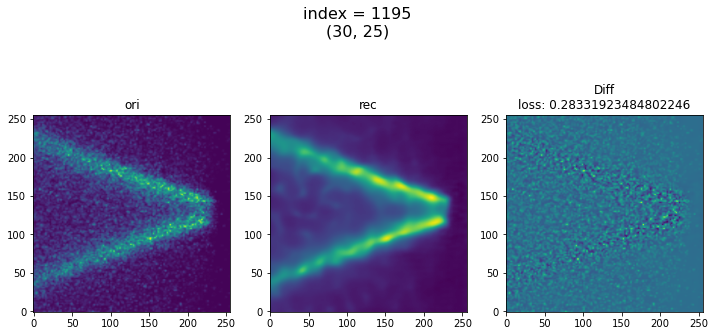

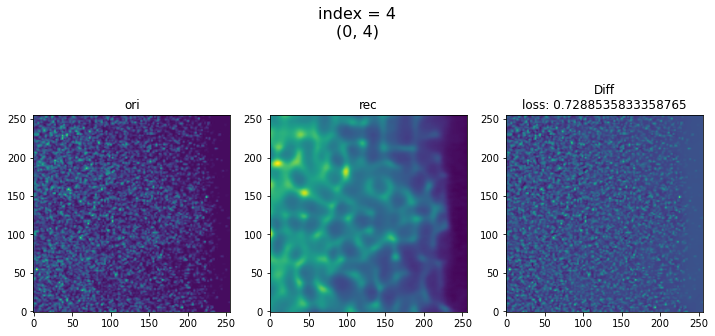

In [9]:
try: showCoord(coords=[30, 25], dataHere=processedData)
except: pass
showCoord(index=4, dataHere=processedData)

In [10]:
# imgs = processedData["img"]
# recImgs = processedData["rec"]
# diffimgs = processedData["diff"]
# losss = processedData["loss"]

# print(f"{np.array(imgs).shape=}")

##___________Filter_____________
# ε = 0.1
# me = np.mean(processedData["img"], axis=(1,2))
# print(max(me), min(me))
# for nr, meanVal in enumerate(me):
#     if(meanVal < min(me)+ ε*(max(me)-min(me)) or axisData["coords"][nr][1] < 3):
#         processedData["img"][nr] = np.zeros(dimension_sizes[2:]) + min(me)
# me = np.mean(processedData["rec"], axis=(1,2))
# print(max(me), min(me))
# for nr, meanVal in enumerate(me):
#     if(meanVal < min(me)+ ε*(max(me)-min(me)) or axisData["coords"][nr][1] < 3):
#         processedData["rec"][nr] = np.zeros(dimension_sizes[2:]) + min(me)




sumImg = np.mean(processedData["img"], axis=(1,2)); print("img done")
sumImgRec = np.mean(processedData["rec"], axis=(1,2)); print("rec done")
sumDiff = np.sum(-processedData["diff"], axis=(1,2)) / np.absolute(sumImg); print("diff done")

# print(sumImg)
# print(np.max(processedData["img"]), np.min(processedData["img"]))

img done
rec done
diff done


Text(0, 0.5, 'y')

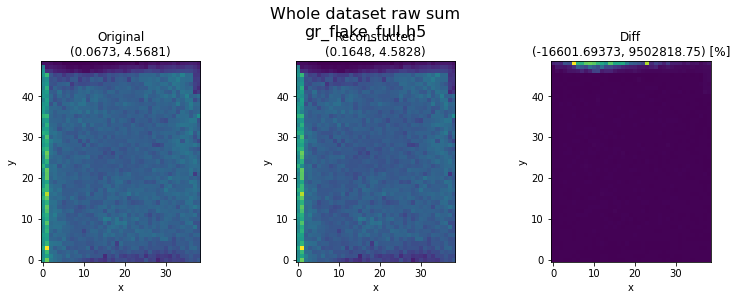

In [11]:
grid = [
    ["ori", "rec", "diff"],
]
fig, axes = plt.subplot_mosaic(grid, figsize=(12, 4.5))
fig.subplots_adjust(wspace=0.6)
fig.suptitle(f"Whole dataset raw sum\n{filename}", fontsize=16)


clim = sumImg.min(), sumImg.max()
axes["ori"].imshow(turnBackToGrid(sumImg, axisData), cmap="viridis", clim=clim, origin="lower")
axes["ori"].set_title(f"Original\n({round(clim[0]*10000)/10000}, {round(clim[1]*10000)/10000})")
axes["ori"].set_xlabel("x")
axes["ori"].set_ylabel("y")

clim = sumImgRec.min(), sumImgRec.max()
axes["rec"].imshow(turnBackToGrid(sumImgRec, axisData), cmap="viridis", clim=clim, origin="lower")
axes["rec"].set_title(f"Reconstucted\n({round(clim[0]*10000)/10000}, {round(clim[1]*10000)/10000})")
axes["rec"].set_xlabel("x")
axes["rec"].set_ylabel("y")

clim = sumDiff.min(), sumDiff.max()  #0.05 plejer at se ret cool ud
axes["diff"].imshow(turnBackToGrid(sumDiff, axisData, -1), cmap="viridis", clim=clim, origin="lower")
axes["diff"].set_title(f"Diff\n({round(clim[0]*100, 5)}, {round(clim[1]*100, 5)}) [%]")
axes["diff"].set_xlabel("x")
axes["diff"].set_ylabel("y")


# Clustering

In [12]:
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap 

def process_dataset(npimg, x_res, y_res):
    num_pix_per_x = INPUT_SHAPE[0] // x_res
    num_pix_per_y = INPUT_SHAPE[1] // y_res

    # Calculate integrated intensities
    intensities = np.zeros((num_pix_per_x * num_pix_per_y, 1))
    box_count = 0
    for nrx in range(num_pix_per_x):
        for nry in range(num_pix_per_y):
            box = npimg[(nrx)*x_res :(nrx+1)*x_res, (nry)*y_res :(nry+1)*y_res]
            intensities[box_count, 0] = np.sum(box)
            box_count += 1
            
    # Normalize the intensities such that the maximum (for each set of data run through this routine) is 100.
    max_intensity = np.max(intensities)
    intensities = (intensities / max_intensity) * 100


    return intensities

In [13]:
dimension_labels = ["x", "y", "e", "k"]
dimension_sizes = (axisData["dims"][0], axisData["dims"][1], 256, 256)
# print(axisData["axis_names"])
print(dimension_labels)
print(dimension_sizes)

['x', 'y', 'e', 'k']
(49, 39, 256, 256)


In [14]:
dimension_labels = ["x", "y", "e", "k"]
dimension_sizes = (axisData["dims"][0], axisData["dims"][1], 256, 256)

if(godfil):
    bigImg = np.reshape(processedData["img"], dimension_sizes)
    bigRec = np.reshape(processedData["rec"], dimension_sizes)
else:
    bigImg = np.zeros(dimension_sizes) 
    bigImgRec = np.zeros(dimension_sizes) 
    for nr, (i, j) in enumerate(axisData["coords"]): 
        bigImg[int(i), int(j)] = processedData["img"][nr]
        bigImgRec[int(i), int(j)] = processedData["rec"][nr]

print(bigImg.shape)
# del(processedData)
# del(data)




(49, 39, 256, 256)


In [15]:
# n_clusters = 6
# intensities = np.reshape(sumImg.flatten(), (-1, 1))
# kmeans_intensities = KMeans(n_clusters=n_clusters, n_init=400, random_state=0).fit(intensities).labels_
# kmeans_intensities = np.array(kmeans_intensities)
# kmeans_intensities = np.reshape(kmeans_intensities, dimension_sizes[:2])

# intensities = np.reshape(sumImgRec.flatten(), (-1, 1))
# kmeans_intensities_rec = KMeans(n_clusters=n_clusters, n_init=400, random_state=0).fit(intensities).labels_
# kmeans_intensities_rec = np.array(kmeans_intensities_rec)
# kmeans_intensities_rec = np.reshape(kmeans_intensities_rec, dimension_sizes[:2])




In [16]:
# mat = np.zeros((n_clusters, n_clusters))
# for i in range(kmeans_intensities.shape[0]):
#     for j in range(kmeans_intensities.shape[1]):
#         mat[kmeans_intensities[i,j], kmeans_intensities_rec[i,j]] += 1

# print(mat)

# #Farvelægger recClMap med de tilsvarende farver fra imgClMap
# conList = list(np.argmax(mat, axis=1))
# print(conList)
# sameColour = False
# if(len(set(conList)) == len(conList)):  #Hvis alle farverne har et match
#     sameColour = True
#     for i in range(kmeans_intensities.shape[0]):
#         for j in range(kmeans_intensities.shape[1]):
#             kmeans_intensities_rec[i, j] = conList.index(kmeans_intensities_rec[i,j])

# if(sameColour):
#     diffClMap = kmeans_intensities - kmeans_intensities_rec
#     diffClMap = np.where(diffClMap!=0, 1, 0)
#     showCoord(imgs=[[kmeans_intensities, "Original"], [kmeans_intensities_rec, "Recreated"], [diffClMap, "Diffs"]])
# else:
#     showCoord(imgs=[[kmeans_intensities, "Ori"], [kmeans_intensities_rec, "rec"]])

processing full stack:   0%|          | 0/1911 [00:00<?, ?spectra/s]

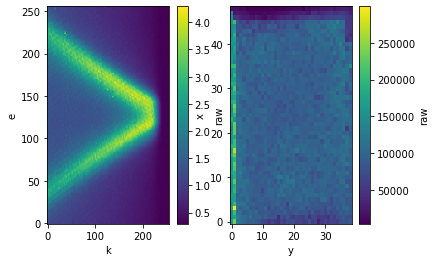

In [17]:

coords = {d: np.arange(s) for d, s in zip(dimension_labels, bigImg.shape)}
xarrImg = xr.DataArray(data=bigImg, dims=dimension_labels, coords=coords, name="raw")
xdsetImg = xarrImg.to_dataset()
clImg = Cluster(xdsetImg)

clImg.navigation_dimensions = ['x','y']
clImg.signal_dimensions = ['e','k']

fig,ax = plt.subplots(1,2)
clImg.source.mean(clImg.navigation_dimensions).plot(ax=ax[0])
clImg.source.sum(clImg.signal_dimensions).plot(ax=ax[1])
listImg = clImg.pre_process([ # a list of transformations we want to apply to each spectrum before feeding it to kmeans
        transform.Resize((256, 256)), # reshape the image
        transform.Rotate(90), # rotate by some angle
        transform.ToTensor(), # necessary for DCT
        transform.DCT_2D(n_components=256*256), # compute the dct transform and pick the first n components
        transform.ToNumpy(), # transform back to np.ndarrays (scikit kmeans needs this as input)
        transform.Flatten(), # kmeans works on 1D vectors, not images
    ])

processing full stack:   0%|          | 0/1911 [00:00<?, ?spectra/s]

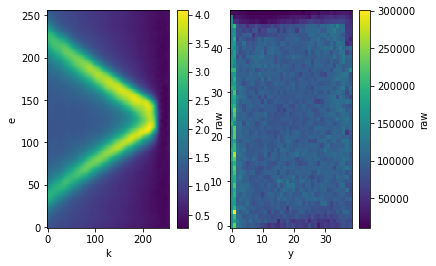

In [18]:
xarrRec = xr.DataArray(data=bigRec, dims=dimension_labels, coords=coords, name="raw")
xdsetRec = xarrRec.to_dataset()
clRec = Cluster(xdsetRec)

clRec.navigation_dimensions = ['x','y']
clRec.signal_dimensions = ['e','k']

fig,ax = plt.subplots(1,2)
clRec.source.mean(clRec.navigation_dimensions).plot(ax=ax[0])
clRec.source.sum(clRec.signal_dimensions).plot(ax=ax[1])
listRec = clRec.pre_process([ # a list of transformations we want to apply to each spectrum before feeding it to kmeans
        transform.Resize((256, 256)), # reshape the image
        transform.Rotate(90), # rotate by some angle
        transform.ToTensor(), # necessary for DCT
        transform.DCT_2D(n_components=256*256), # compute the dct transform and pick the first n components
        transform.ToNumpy(), # transform back to np.ndarrays (scikit kmeans needs this as input)
        transform.Flatten(), # kmeans works on 1D vectors, not images
    ])

In [19]:
n_clusters=8
print(listImg)
print(listRec)
# print(listImg)
# chosen = RandomState().permutation(len(listImg))[: n_clusters]
# init = np.array(listImg, dtype=np.float64)[chosen]

clImg.fit(n_clusters=n_clusters, algorithm='marigold', n_init=1)
clRec.fit(n_clusters=n_clusters, algorithm='marigold', n_init=1)
# clImg.fit(n_clusters=n_clusters)
# clRec.fit(n_clusters=n_clusters)



(1911, 65536)
(1911, 65536)


Samme farver: True


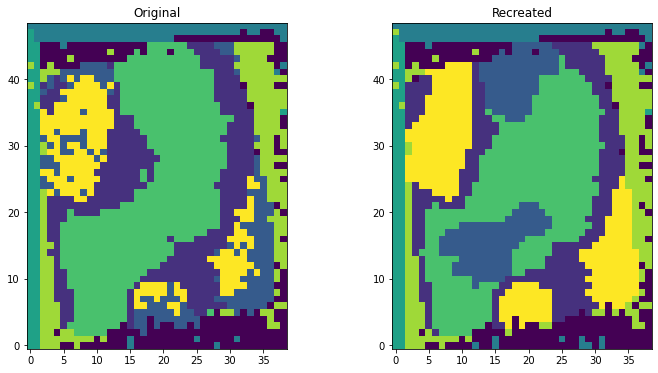

In [ ]:
#Giver dem de samme farver

imgClMap = np.array(clImg.cluster_map)
recClMap = np.array(clRec.cluster_map)

#Finder sammenhængen imellem de to billeders clusters
mat = np.zeros((n_clusters, n_clusters))
for i in range(imgClMap.shape[0]):
    for j in range(imgClMap.shape[1]):
        mat[imgClMap[i,j], recClMap[i,j]] += 1

mapper = list(range(n_clusters))
mat = (mat/np.abs(np.reshape(np.sum(mat, axis=1), (-1, 1)))*mat)
# for _ in range(n_clusters):
#     max1 = np.argmax(mat, axis=(1))
#     max2 = np.argmax(mat[range(n_clusters), max1])
#     print(np.round(mat, 3))
#     # print(max1)
#     # print(max2)
#     # mat[:, [max1[max2], max2]] = mat[:, [max2, max1[max2]]]
#     # mat[:, max1[max2]] = 0
#     mat[max2, :] = 0
#     mat[max2, max1[max2]] = -1
#     mapper[max1[max2]] = max2
# mat *= -1
# print(mapper)
# print(np.round(mat,3))
conList = list(np.argmax(mat, axis=1))
conSet = set(conList)
while(len(conSet) != len(conList)):   #Hvis alle farverne ikke har et match
    #Finder indexet for rækken med to referencer
    badVal = sorted(list(conSet))
    for nr, i in enumerate(badVal):
        if(nr != i):  #finder fejlen
            badVal = nr
            break
        badVal = nr+1
    badVal = conList[badVal] 

    mat[np.argmax(mat[:, badVal]), badVal] = 0 #Sørger for at det er den næststørste værdi der ændre sig

    conList[np.argmax(mat[:, badVal])] = list(set(range(n_clusters)).difference(conSet))[0] #Giver tilfældigt en af de tilbageværende værdier
    conSet = set(conList)


#Farvelægger recClMap med de tilsvarende farver fra imgClMap
# print(conList)
sameColour = False
if(len(set(conList)) == len(conList)):  #Hvis alle farverne har et match
    sameColour = True
    for i in range(imgClMap.shape[0]):
        for j in range(imgClMap.shape[1]):
            recClMap[i, j] = conList.index(recClMap[i,j])
print(f"Samme farver: {sameColour}")


showCoord(imgs=[[imgClMap, "Original"], [recClMap, "Recreated"]])



In [21]:
if(sameColour):
    diffClMap = imgClMap - recClMap
    diffClMap = np.where(diffClMap!=0, 1, 0)
    showCoord(imgs=[[imgClMap, "Original"], [recClMap, "Recreated"], [diffClMap, "Diffs"]])

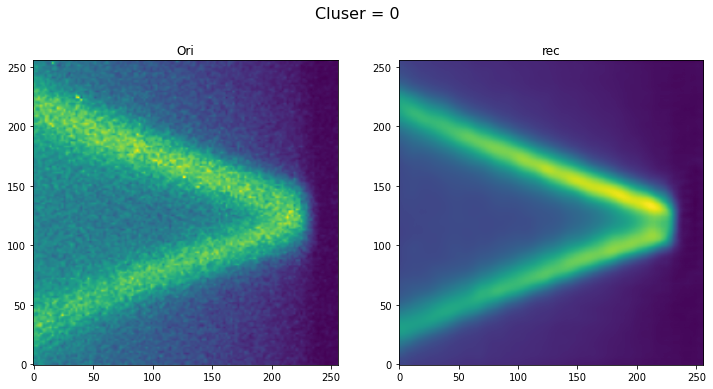

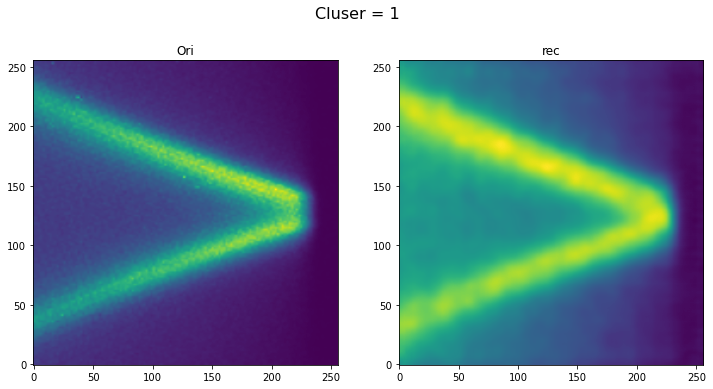

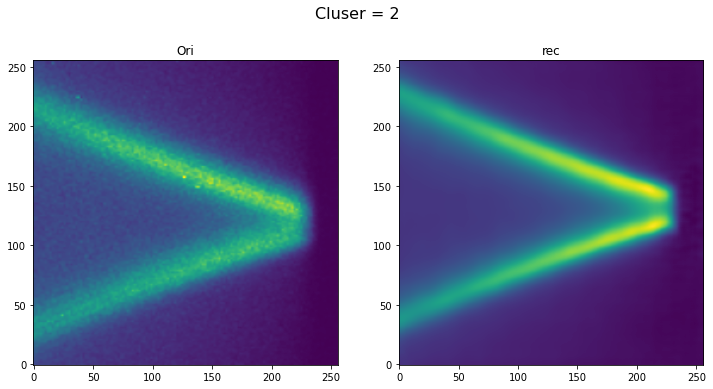

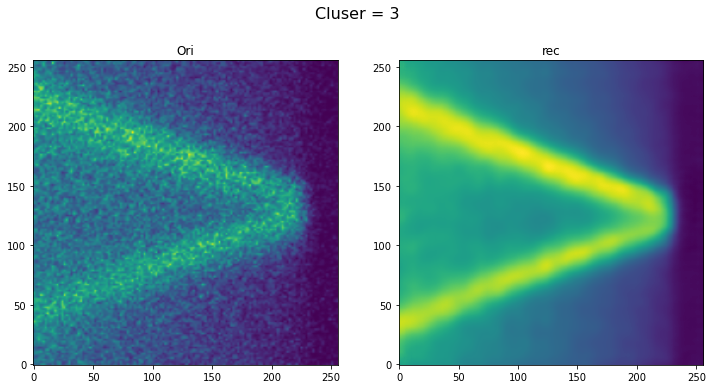

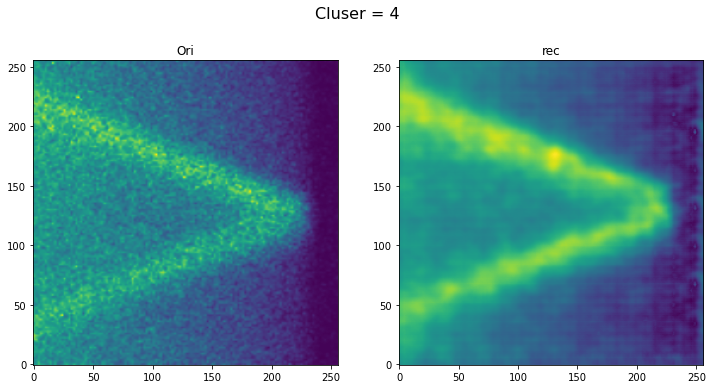

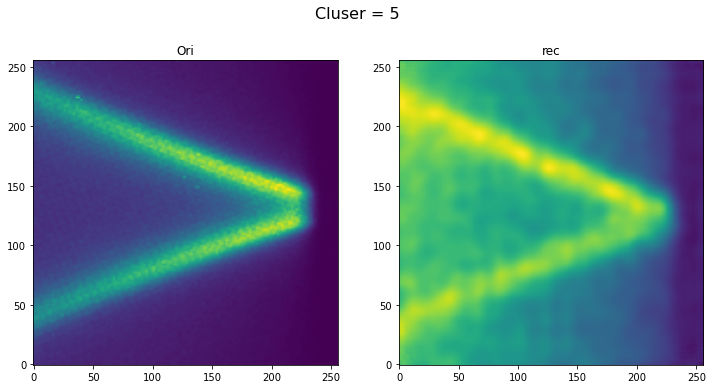

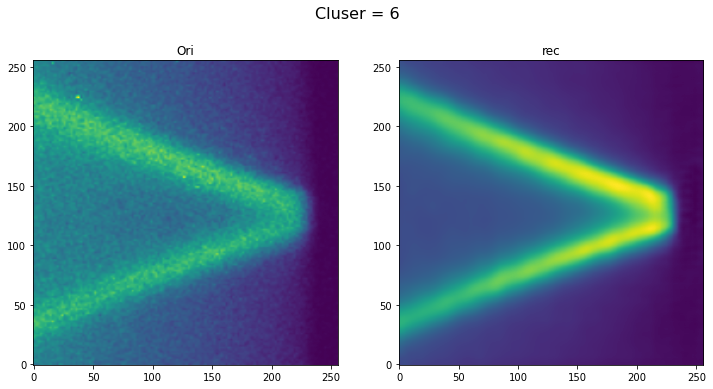

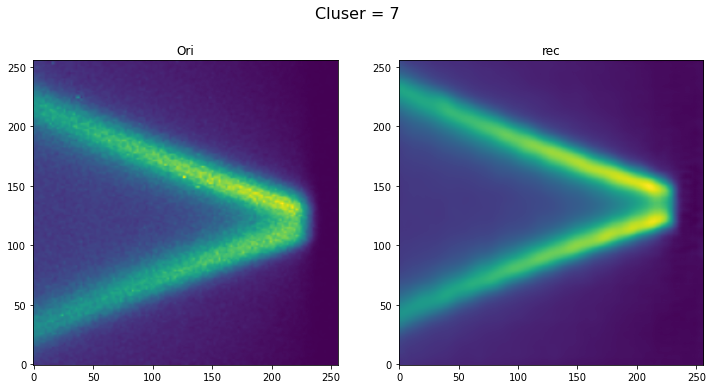

In [22]:
# print(np.where(imgClMap == 0)[0])
for clus in range(n_clusters):
    imgs1 = np.zeros((256, 256))
    recs1 = np.zeros((256, 256))
    for i in range(imgClMap.shape[0]):
        for j in range(imgClMap.shape[1]):
            if(imgClMap[i, j] == clus):
                imgs1 += bigImg[i, j]
            if(recClMap[i, j] == clus):
                recs1 += bigRec[i, j]

    s = f"Cluser = {clus}"
    showCoord(imgs = [[imgs1, "Ori"], [recs1, "rec"]], title=s)
    



In [23]:
# print(np.where((imgClMap == 0).all(0)))

print(clImg.cluster_sizes)

<xarray.DataArray (cluster: 8)>
array([218., 360., 180., 104.,  92., 568., 197., 192.])
Coordinates:
  * cluster  (cluster) int32 0 1 2 3 4 5 6 7
Attributes:
    init:          k-means++
    n_clusters:    8
    n_init:        1
    tol:           0.0001
    max_iter:      100
    verbose:       False
    random_state:  None
    algorithm:     marigold
    inertia:       60761923.63953944
    n_iter:        26
